<a href="https://colab.research.google.com/github/alagarde-bit/Computer-Vision/blob/main/Lagarde_HW05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 4466 Computer Vision
## Homework 5- Birds
### 4/16/2022
### *** Alex Lagarde ***




In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler

In [19]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1NPjoulV3fFxe5y2NWNqcLUjSWzPJckaX',
                                    dest_path= '/content/data.zip',
                                    unzip=True)

gdd.download_file_from_google_drive(file_id='1rmX_B6rphcJo6H-o5USyFVw_jqL_CRrI',
                                    dest_path='/content/test.zip',
                                    unzip=True)

In [20]:
batch_size = 32
img_height = 180
img_width = 180

data_dir = 'data'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
['bird', 'not_bird']


In [43]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip('horizontal_and_vertical'),
  layers.RandomRotation(0.2)
])
resnet_model = Sequential()

pretrained_model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                           input_shape=[img_height,img_width,3],
                                                           pooling = 'avg',
                                                           classes = len(class_names),
                                                           weights = 'imagenet')
for layer in pretrained_model.layers[:143]:
  layer.trainable = False
resnet_model.add(pretrained_model)
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

epochs = 11

def step_decay(epoch):
  decay_rate = 1
  initial_learning_rate = 0.001
  lrate = initial_learning_rate * (1/(1+(decay_rate * epoch)))
  print(lrate)
  return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
# num_train_steps = len(train_ds) * epochs
# lr_scheduler  = PolynomialDecay(
#     initial_learning_rate = 0.00001, 
#     end_learning_rate = 0.000001,
#     decay_steps = num_train_steps
# )



In [44]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss = 'sparse_categorical_crossentropy',
                    metrics=['sparse_categorical_accuracy'])

In [45]:

history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [lrate]
)


0.001
Epoch 1/11
250/250 [==============================] - 67s 250ms/step - loss: 0.3391 - sparse_categorical_accuracy: 0.8618 - val_loss: 0.3158 - val_sparse_categorical_accuracy: 0.8810 - lr: 0.0010
0.0005
Epoch 2/11
250/250 [==============================] - 61s 246ms/step - loss: 0.1108 - sparse_categorical_accuracy: 0.9601 - val_loss: 0.2163 - val_sparse_categorical_accuracy: 0.9180 - lr: 5.0000e-04
0.0003333333333333333
Epoch 3/11
250/250 [==============================] - 61s 245ms/step - loss: 0.0305 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.2479 - val_sparse_categorical_accuracy: 0.9230 - lr: 3.3333e-04
0.00025
Epoch 4/11
250/250 [==============================] - 61s 245ms/step - loss: 0.0049 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.2603 - val_sparse_categorical_accuracy: 0.9255 - lr: 2.5000e-04
0.0002
Epoch 5/11
250/250 [==============================] - 61s 246ms/step - loss: 0.0011 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2866 - val_sparse_

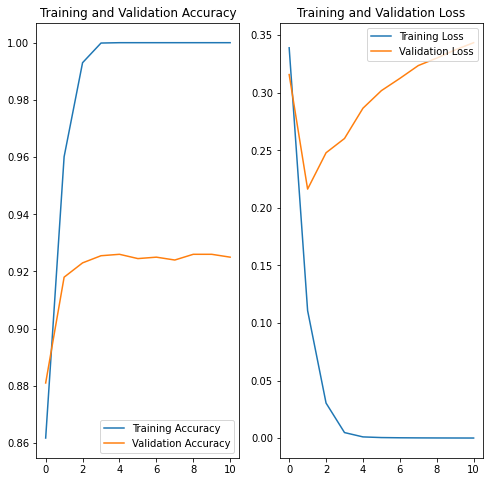

In [46]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
path = '/content/test'
filenames = sorted(os.listdir(path))

test_images = []
test_preds = []
for file in filenames:
  test_images.append(file)


for idx, test_image in enumerate(test_images):
  img = cv2.imread(os.path.join(path, test_image))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (img_width, img_height))
  img = np.reshape(img, (1, img.shape[0], img.shape[1], 3))
  batch_predictions = resnet_model.predict(img)
  predictions = batch_predictions[0]
  pred_label_idx = np.argmax(predictions)
  test_preds.append(pred_label_idx)


In [48]:
textfile = open('birdchecker.txt', "w")
for element in test_preds:
  if element == 1:
    textfile.write(str(0) + "\n")
  else:
    textfile.write(str(1) + "\n")
textfile.close()